# House Price Prediction


## Models

This notebook implements regression models for predictive problem, with introduction, algorithm, and special toptic for each model. Following single regression model, two ensemble methods, bagging and random forest, are also applied in pursuit of better prediction.

## Overview
#### Regression
1. Linear Regression
    - Probablistic View of Linear Regression
2. Ridge Regression
    - Probablisitc View: Ridge Regression and Bayesian Modeling
3. Sparse Regression (Lasso)
4. Elastic Net
    - Model Comparison - Linear Regression, Ridge, and Lasso
5. Kernel Ridge
    - Kernels
6. Regression Tree

#### Ensemble
1. Bagging
    - Algorithm
    - Model Improvement
2. Random Forest
    - Algorithm

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
### Read in the data
df = pd.read_csv('../project-house-price-prediction/data/train.csv')
df_test = pd.read_csv('../project-house-price-prediction/data/test.csv')

## Data
The data preparation below follows the data exploration done in the notebook data-exploration-and-preprocessing.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
class CleanHouseAttributes(BaseEstimator, TransformerMixin):
    """Apply rules during data exploration to clean house price dataset"""
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, df_house_price, cols_to_drop, target_col=[]):
        # Age of building/remodle from YearBuilt and YearRemodAdd
        df_house_price['AgeBuilding'] = 2012 - df_house_price['YearBuilt']
        df_house_price['AgeRemodel'] = 2012 - df_house_price['YearRemodAdd']
        
        # Create boolean variables for Alley, PoolQC, and Fence
        df_house_price['HasAlley'] = ~df_house_price[['Alley']].isnull()
        df_house_price['HasPool'] = ~df_house_price[['PoolQC']].isnull()
        df_house_price['Fence'] = ~df_house_price[['Fence']].isnull()

        # Remove categories not exist in test.csv
        df_filtered = df_house_price[(df_house_price['HouseStyle'] != '2.5Fin') &
                                     (~df_house_price['RoofMatl'].isin(['Membran', 'Roll', 'ClyTile', 'Metal'])) &
                                     (~df_house_price['Exterior1st'].isin(['Stone', 'ImStucc'])) &
                                     (df_house_price['Exterior2nd'] != 'Other') &
                                     (df_house_price['Electrical'] != 'Mix')]
        
        # Drop columns
        df_dropped = df_filtered.drop(cols_to_drop + target_col + ['HasAlley', 'HasPool', 'Fence'], axis=1)
               
        # Fill NA for numeric columns
        df_numeric = df_dropped.select_dtypes(include=['int64', 'float64']).apply(lambda x: x.fillna(x.mean()), axis=1)
        
        # Fill NA for non-numcric columns with the most frequent category
        df_nonNumeric = df_dropped.select_dtypes(include=['object']).apply(lambda x: x.fillna(x.mode()[0]))
                
        X = pd.concat([df_numeric, pd.get_dummies(df_nonNumeric)], axis=1)
        y = df_filtered[target_col]

        return X, y

In [5]:
drop_cols = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotalBsmtSF', 
             'TotRmsAbvGrd', 'MoSold', 'YrSold', 'GarageQual', 'Street', 'Alley', 
             'Utilities', 'LandSlope', 'Condition2', 'Heating', 'Functional', 
             'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
target_col = ['SalePrice']

In [6]:
X, y = CleanHouseAttributes().transform(df, drop_cols, target_col)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1459
Columns: 223 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(31), uint8(192)
memory usage: 631.3 KB


In [7]:
X_test, y_test = CleanHouseAttributes().transform(df_test, drop_cols)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Columns: 223 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(31), uint8(192)
memory usage: 638.3 KB


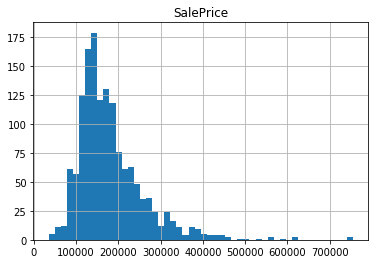

In [8]:
y.hist(bins=50)
plt.show()

<a id = "sklearn"></a>
## Regression

### Probblem Definition
**Input:** $x \in \mathbb{R}^{d}, d = 243$

**Output:** $y \in \mathbb{R}$

**Goal:** Find a function $f: \mathbb{R}^{d} \rightarrow \mathbb{R}$ such that $y \approx f(x;w)$ for the data pair $(x, y)$. $f(x;w)$ is call a $\textit{regression funciton}$. Its free parameters are $w$.

### 1. Linear Regression

A regression method is called $\textit{linear}$ if the prediction $f$ is a linear function of the unknown parameters $w$. 

The linear regression has the form
$$y_{i} \approx f(x_{i};w) = w_{0} + x_{i}^{T}w,$$

or in matrix form, 
$$y = \mathbf{X}w,$$
where a vector of 1 is attached in the first column of matrix $\mathbf{X}$.

With least square solution, we get the loss function for linear regression as
$$L = \sum_{i=1}^{n}\left(y_{i}-x_{i}^{T}w\right)^{2} = \|y -\mathbf{X}w\|^{2} = (y-\mathbf{X}w)^{T}(y-\mathbf{X}w)$$

If we take the gradient with respect to $w$, we find that
$$\nabla_{w}L = 2\mathbf{X}^T\mathbf{X}w-2\mathbf{X}^Ty = 0 \Rightarrow  w_{LS} = (\mathbf{X}^T \mathbf{X})^{−1}\mathbf{X}^T y$$

### Probablistic View of Linear Regression

Gaussian density in $n$ dimensions: Assume a diagonal covariance matrix $\Sigma = \sigma^2I$. The density is 
$$p(y|\mu, \sigma^2) = \frac{1}{(2\pi\sigma^2)^\frac{n}{2}} \exp (-\frac{1}{2\sigma^2}(y-\mu)^T(y-\mu)).$$
Plug $\mu=Xw$ into the multivariate Gaussian distribution and solve for $w$ using maximum likelihood.
$$w_{ML} = \operatorname*{arg\,max}_w \ln p(y|\mu = Xw, \sigma^2) 
= \operatorname*{arg\,max}_w -\frac{1}{2\sigma^2}\|y-Xw\|^2-\frac{n}{2}\ln(2\pi\sigma^2).$$

**Least squres (LS) and maximum likelihood (ML) share the same solution.**

$$\text{LS: } \operatorname*{arg\,min}_w\|y-Xw\|^2  \Leftrightarrow  \text{ML: } \operatorname*{arg\,max}_w-\frac{1}{2\sigma^2}\|y-Xw\|^2$$

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R-squared:", lr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.87554536605
RMSE: 28925.9097315


#### Note: See appendix for interpreting the coefficient of linear regression
If the purpose of builing linear regression models is for interpretation. The package `statsmodels.api` would be a better option then the package `sklearn` for providing coefficients with p-value.

In [11]:
import statsmodels.api as sm

In [12]:
X_sm = sm.add_constant(X)
lr_sm = sm.OLS(y, X_sm)
lr_sm = lr_sm.fit()
print(lr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     72.36
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        08:03:49   Log-Likelihood:                -16531.
No. Observations:                1443   AIC:                         3.344e+04
Df Residuals:                    1252   BIC:                         3.445e+04
Df Model:                         190                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4137.42

### 2. Ridge Regression
Least square solution is unbiased but potentially has high variance. The value in $w_{ML}$ may be huge. In general, we often want to constraint the model parameters. One way is to add regularization. Ridge Regression addresses variance issues with $w_{ML}$ by using the squared penalty on the gression coefficient vector $w$,
$$w_{RR} = \operatorname*{arg\,min}_w \|y-\mathbf{X}w\|^2+\lambda\|w\|^2 = (\lambda\mathbf{I}+\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^Ty.$$

### Probablisitc View: Ridge Regression and Bayesian Modeling
Adding a $l2$ regularization term to linear regression is like defining a prior on the unknown parameter $w$ and trying to learn its posterior. 

In Bayesian setting, we can model the data as:

**Likelihood:** $y \sim N(Xw, \sigma^2I)$

**Prior:** $w \sim N(0, \lambda^{-1}I)$ Then 
$$p(w) = (\frac{\lambda}{2\pi})^{\frac{d}{2}} e^{-\frac{\lambda}{2}w^Tw}$$

Maximum $\textit{a poseriori}$ (MAP) estimation seeks the most probable value $w$ under the posterior:
$$w_{MAP} = \operatorname*{arg\,max}_w\ln p(w|y,X) = \operatorname*{arg\,max}_w\ln p(y|w,X) + \ln p(w)$$
$$=\operatorname*{arg\,max}_w\frac{1}{2\sigma^2}(y-Xw)^T(y-Xw) - \frac{\lambda}{2}w^Tw + const.$$

Take gradient of the function, we can get the solution for $w_{MAP}$ = $(\lambda\sigma^2I+X^TX)^{-1}X^Ty$.

**Notice that $w_{MAP} = w_{RR}$**

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [14]:
param_grid = {'alpha': np.linspace(0, 10, 101)}
ridge = Ridge(normalize=True)
gs_ridge = GridSearchCV(ridge, param_grid, cv=5)
gs_ridge.fit(X_train, y_train)
print(gs_ridge.best_params_, gs_ridge.best_score_)

y_pred = gs_ridge.predict(X_test)
print("R-squared:", gs_ridge.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 0.40000000000000002} 0.857969025909
R-squared: 0.879616363038
RMSE: 28448.8830927


### 3. Sparse Regression (Lasso)
The pentalty term of Lasso will select a small subset of the d dimensions and switch off the rest, encourasing sparse solutions.

**LASSO:** Least Absolute Shrinkage and Selection Operator

With the LASSO, we replac the $l_2$ penalty with an $l_1$ penalty:
$$w_{lasso} = \operatorname*{arg\,min}_w \|y-\mathbf{X}w\|^2+\lambda\|w\|_1,$$
where
$$\|w\|_1 = \sum_{j=1}^{d}|w_j|.$$

In [15]:
# Suppress warnings from using Lasso
import warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [16]:
from sklearn.linear_model import Lasso

In [17]:
param_grid = {'alpha': np.linspace(0, 10, 11)}
lasso = Lasso(normalize=True)
gs_lasso = GridSearchCV(lasso, param_grid, cv=5)
gs_lasso.fit(X_train, y_train)
print(gs_lasso.best_params_, gs_lasso.best_score_)

y_pred = gs_lasso.predict(X_test)
print("R-squared:", gs_lasso.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 10.0} 0.852771042618
R-squared: 0.887929827402
RMSE: 27448.9989803


### 4. Elastic Net
Elastic Net combines $l_1$ and $l_2$ penalties.
$$w_{elastic} = \operatorname*{argmin}_w \|y-\mathbf{X}w\|^2+\lambda_2\|w\|^2+\lambda_1\|w\|_1$$

In [18]:
from sklearn.linear_model import ElasticNet

In [19]:
param_grid = {'alpha': np.linspace(0, 1, 5), 'l1_ratio': [0.1, 1]}
en = ElasticNet()
gs_en = GridSearchCV(en, param_grid, cv=5)
gs_en.fit(X_train, y_train)
print(gs_en.best_params_, gs_en.best_score_)

y_pred = gs_en.predict(X_test)
print("R-squared:", gs_en.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 0.25, 'l1_ratio': 0.1} 0.837897356181
R-squared: 0.869669502341
RMSE: 29600.8728535


### Model Comparison - Linear Regression, Ridge, Lasso, and Elastic Net
#### Predictive Performance
In general, regression models with regularization terms have better prediction, or generalization, than linear regression.

In [20]:
df_variance = pd.DataFrame({})
# Apply best models from grid search
for (k,v) in zip(['Linear Regression', 'Ridge Regression', 'Sparse Regression', 'Elastic Net'],
                 [lr, Ridge(alpha=0.7), Lasso(alpha=10), ElasticNet(alpha=1, l1_ratio=1)]):
    cv_results = cross_val_score(v, X, y, cv=5)
    df_variance[k] = cv_results

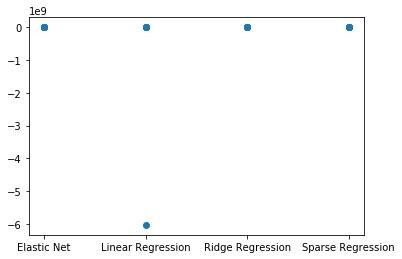

In [21]:
df_variance_plot = df_variance.melt()
plt.plot(df_variance_plot['variable'], df_variance_plot['value'], 'o')
plt.show()

#### Coefficients - Quadratic Penalty (Ridge) vs Linear Penalty (Lasso)
- Suppose $w_k$ is large, all other$w_j$ are very small but non-zero
- Linear penalty: Penalty should keep $w_k$ and push other $w_j$ to zero
- Quadratic penalty: Will favor entries $w_j$ with all have similar size, and so it will push $w_k$ towards small value.

Overall, a quadratic penalty favors many small but non-zero values, and a linear penalty term achieves sparsity

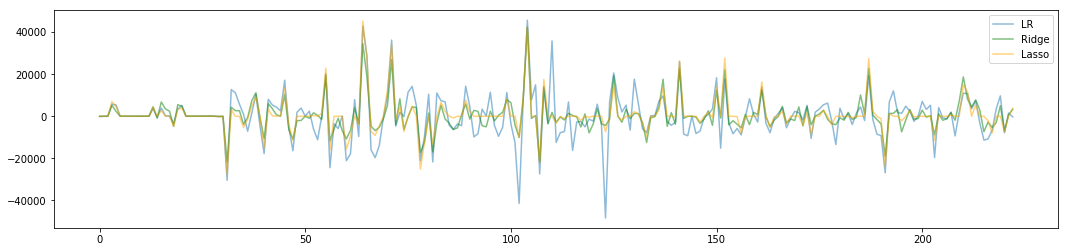

In [22]:
plt.figure(figsize=(18, 4))
plt.plot(lr.coef_.squeeze(), label='LR', alpha = 0.5)
plt.plot(gs_ridge.best_estimator_.coef_.squeeze(), color = 'green', label='Ridge', alpha =0.5)
plt.plot(gs_lasso.best_estimator_.coef_, color = 'orange', label='Lasso', alpha =0.5)
plt.legend();

### 5. Kernel Ridge
Definition from sklearn: Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data.

### Kernels
A kernel $K(\cdot,\cdot): \mathbb{R}^d \times \mathbb{R}^d \rightarrow$ is a symmetric function defined as follows:

For any set of n data points $x_1,...,x_n \in \mathbb{R}^d$, the $n \times n$ matrix $K$, where $K_{ij} = K(x_i, x_j)$, is positive semidefinite.

From Mercer's theorem, if the function $K(\cdot,\cdot)$ satisfies the above properties, then there exists a mapping $\pi: \mathbb{R}^d \rightarrow \mathbb{R}^D$ such that
$$K(x_i, x_j) = \pi(x_i)^T\pi(x_j).$$

We usually only define $K(\cdot,\cdot)$ and avoid ever using $\phi(\cdot)$. However, the kernel $K(\cdot,\cdot)$ implies that x_i and x_j have been mapped into a higher, or infinite, dimension $D$ to get the output.

In [23]:
from sklearn.kernel_ridge import KernelRidge

In [24]:
param_grid = {'alpha': [0.1, 1, 10, 100]}
kr = KernelRidge()
gs_kr = GridSearchCV(kr, param_grid, cv=5)
gs_kr.fit(X_train, y_train)
print(gs_kr.best_params_, gs_kr.best_score_)

y_pred = gs_kr.predict(X_test)
print("R-squared:", gs_kr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

{'alpha': 10} 0.854513811995
R-squared: 0.887205666312
RMSE: 27537.5394431


### 6. Regression Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
param_grid = {'max_depth': np.arange(4,9), 
              'min_samples_split': np.arange(2,11), 
              'max_features': ['auto', 'sqrt']}
dt = DecisionTreeRegressor()
gs_dt = GridSearchCV(dt, param_grid, cv=5)
gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_, gs_dt.best_score_)

y_pred = gs_dt.predict(X_test)
print(gs_dt.score(X_test, y_test))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

{'min_samples_split': 9, 'max_depth': 7, 'max_features': 'auto'} 0.695009862103
0.771352769716
39207.0767775


## Ensemble Models

### Bagging

Bagging uses the boostrap for regression or classification: **Bagging** = **B**oostrap **agg**regation

#### Algorithm
For $b = 1,...,B$:
1. Draw a boostrap sample $\mathbb{B}_b$ of size $n$ from training data. (Boostrap = resampling with replacement)
2. Train a classifier or regression model $f_b$ on $\mathbb{B}_b$
    - For a new point $x_0$, compute:
    $$f_avg(X_0) = \frac{1}{B}\sum{b=1}^{B}f_b(X_0)$$
    - For regression, f_avg(x_0) is the prediction
    - For classification, view f_avg(x_0) as an average over $B$ votes. Pick the majority.

In [27]:
from sklearn.ensemble import BaggingRegressor

In [28]:
def apply_bagging(model, X_train, y_train, X_test, y_test, iteration = 10):
    bagging = BaggingRegressor(model,
                               n_estimators=iteration)
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)
    print('R-squared: {} RMSE: {}'.format(bagging.score(X_test, y_test), 
                                          np.sqrt(mean_squared_error(y_test, y_pred))))

In [29]:
# initiate best models from previous codes
lr = LinearRegression()
ridge = Ridge(alpha=0.7, normalize=True)
lasso = Lasso(alpha=10, normalize=True)
kr = KernelRidge(alpha=10)
dt = DecisionTreeRegressor(max_depth=7, max_features='auto', min_samples_split=9)

models = [lr, ridge, lasso, kr, dt]
model_names = ['Linear Regression',
               'Ridge Regression',
               'Sparse Regression',
               'Kernel Regression',
               'Decision Tree Regression']
for (k, v) in zip(model_names, models):
    print(k)
    apply_bagging(v, X_train, np.ravel(y_train), X_test, y_test, 100)

Linear Regression
R-squared: -573207.6422663371 RMSE: 62078019.85683996
Ridge Regression
R-squared: 0.8703482420457372 RMSE: 29523.694010441923
Sparse Regression
R-squared: 0.8900491541508485 RMSE: 27188.220161573994
Kernel Regression
R-squared: 0.8873744318652382 RMSE: 27516.930571959405
Decision Tree Regression
R-squared: 0.876959594580181 RMSE: 28761.091742617737


#### Model Improvement
- We can further use the parameter max_features in BaggingRegressor to select a subset of features. However, if we use all features by default setting, bagged regressions are correlated. In general, when bootstrap samples are correlated, the benefit of bagging decreases. This could be the reason why bagging doesn't improve much compare to single models.
- Random forests model is a modification of bagging where trees are designed to reduce correlation. The modification is to only consider random subset of dimensions of $x \in \mathbb{R}^d$.

### Random Forest

#### Algorithm
Input parameter: $m$ - a positive integer with $m<d$ often $m \approx \sqrt{d}$
For $b = 1,...,B$:
1. Draw a boostrap sample $\mathbb{B}_b$ of size $n$ from the training data.
2. Train a tree classfier on $\mathbb{B}_b$, where each split is computed as follows:
    - Randomly select $m$ dimensions of $x \in \mathbb{R}^d$ newly chosen for each $b$.
    - Make the best split restricted to that subset of dimensions.

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
param_grid = {'n_estimators':[100, 250, 500],
              'max_depth': [3, 5, 8], 
              'max_features': ['auto', 'sqrt']}
rf = RandomForestRegressor()
gs_rf = GridSearchCV(rf, param_grid, cv=5)
gs_rf.fit(X_train, np.ravel(y_train))
print(gs_rf.best_params_, gs_rf.best_score_)

y_pred = gs_rf.predict(X_test)
print(gs_rf.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, y_pred)))

{'max_depth': 8, 'n_estimators': 500, 'max_features': 'auto'} 0.828238688507
0.883983324093 27928.1198586


## Performance on Kaggle

Using best models for final Kaggle submission, tt turns out that Lasso + Baggins has similar results with Random Forest. However, both are not very competitive models.

In [32]:
# Lasso + Bagging: 0.16457
X_test_kaggle, y_test_kaggle = CleanHouseAttributes().transform(df_test, drop_cols)
bagging = BaggingRegressor(Lasso(alpha=10, normalize=True),
                           n_estimators=100)
bagging.fit(X, np.ravel(y))
y_pred_kaggle = bagging.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv', index=False)

In [33]:
# Random Forest: 0.16539
param_grid = {'n_estimators':[100, 250, 500],
              'max_depth': [3, 5, 8], 
              'max_features': ['auto', 'sqrt']}
rf = RandomForestRegressor()
bagging.fit(X, np.ravel(y))
y_pred_kaggle = bagging.predict(X_test_kaggle)
pd.DataFrame({'Id': df_test.Id.values,
              'SalePrice': np.squeeze(y_pred_kaggle)}).to_csv('../project-house-price-prediction/data/pred.csv', index=False)

## References for Model Introduction and Algorithms
- Applied Machine Learning Certification - Columnbia Engineering Executive Education

#### Note: The coding was done through personal works and researches and not borrowed from the certification course.